In [39]:
import kagglehub
import cv2
import keras
import os
import numpy as np
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# DataSet

In [40]:
# دانلود دیتاست
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-detection


# Pre-Processing

In [41]:
# جدا کردن تصاویر، اسم تصاویر، لیبل ها و باوندینگ باکس ها توی لیست های جدا

# مسیر دیتاست
images_path = os.path.join(path, 'images') # مسیر تصاویر
annotations_path = os.path.join(path, 'annotations') # مسیر انوتیشن‌ ها

# لیست تصاویر و آماده‌سازی داده‌ ها
faces = []
labels = []

for filename in os.listdir(images_path):
    img_path = os.path.join(images_path, filename) # مسیر تصویر
    img = cv2.imread(img_path) # خوندن تصویر
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # تغییر کانال رنگی برای عملکرد بهتر مدل

    # استخراج لیبل و باوندینگ باکس ها از انوتیشنِ تصویر
    xml_file = os.path.join(annotations_path, filename.replace('.png', '.xml'))
    tree = ET.parse(xml_file) # تبدیل انوتیشن به فرمت شی قابل فهم و ساده به صورت درختی
    root = tree.getroot() # ( <annotation>...</annotation> ) ریشه درخت

    for object in root.findall('object'): # پیدا کردن همه آبجکت های توی ریشه. هر آبجکت یه فرد توی تصویره
        class_name = object.find('name').text # کلاس فرد (با ماسک | بدون ماسک | با ماسک نادرست زده شده) بدون تگ
        bounding_box = object.find('bndbox') # باوندینگ باکس فرد

        # مختصات باوندینگ باکس
        x_start = int(bounding_box.find('xmin').text)
        y_start = int(bounding_box.find('ymin').text)
        x_end = int(bounding_box.find('xmax').text)
        y_end = int(bounding_box.find('ymax').text)

        faces.append(cv2.resize(img[y_start:y_end, x_start:x_end], (216, 216))) # اضافه کردن تصویر کراپ شده باوندینگ باکس به لیست چهره ها

        # بررسی تعلق به هر کلاس
        if class_name == 'without_mask':
            labels.append([0])
        elif class_name == 'with_mask':
            labels.append([1])
        elif class_name == 'mask_weared_incorrect':
            labels.append([2])


# تبدیل لیست ها به آرایه نامپای برای پردازش توسط مدل
faces = np.array(faces)
labels = np.array(labels)

# نرمالایز کردن تصاویر
faces = faces.astype('float32') / 255.0

# (80%)تقسیم به داده های ترِین(20%) و تست
train_faces, test_faces, train_labels, test_labels = train_test_split(
    faces, labels, test_size=0.2, shuffle=True
)

# برای محاسبه بهتر تابع هزینه توسط مدل One-Hot Endcoding تبدیل لیبل ها به
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=3)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=3)

# Model Definition

In [42]:
# تعریف مدل

model = keras.Sequential()

model.add(keras.layers.Conv2D(64, (3, 3), padding='valid', input_shape=(216, 216, 3)))
model.add(keras.layers.BatchNormalization()) # برای پردازش سریعتر و پایداری
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), padding='valid'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(keras.layers.Conv2D(256, (3, 3), padding='valid'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(keras.layers.Conv2D(512, (3, 3), padding='valid'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# model.add(keras.layers.Flatten())
model.add(keras.layers.GlobalAveragePooling2D()) # برای حجم محاسبات کمتر  و استخراج ویژگی های کلی

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5)) # برای جلوگیری از اورفیتینگ و محاسبات کمتر
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 214, 214, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 214, 214, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 214, 214, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 107, 107, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 105, 105, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 105, 105, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 105, 105, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 23, 23, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 23, 23, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686,915 (6.44 MB)

 Trainable params: 1,684,995 (6.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Model Trainig

In [43]:
# فیت کردن مدل

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True) # تعریف کال بک

# دیتا آگمنتیشن
augmentation_generator = ImageDataGenerator( # تعریف شی برای ذخیره تنظیمات
    rotation_range=10, # چرخش تصادفی تا 10 درجه
    # width_shift_range=0.1, # جابجایی افقی تا 10% عرض
    # height_shift_range=0.1, # جابجایی عمودی تا 10% ارتفاع
    # zoom_range=0.2, # زوم تصادفی تا 20 درصد
    horizontal_flip=True, # برعکس کردن افقی
    # vertical_flip=True, # برعکس کردن عمودی
    brightness_range=[0.9, 1.1], # تغییر روشنایی بین 90 تا 110درصد
    # shear_range=0.1, # کشیدگی تصویر به اندازه 10 درصد
    # fill_mode='nearest', # پر کردن پیکسل‌های خالی با نزدیکترین مقدار
)

# با ژنراتور دیتا آگمنتیشن
trained_model = model.fit(
    augmentation_generator.flow(train_faces, train_labels_onehot, batch_size=64), # تعریف ژنراتور
    steps_per_epoch=(len(train_faces) // 64) + 1, # تعداد گام هایی که ژنراتور توی هر ایپاک باید داده ها رو به مدل بده
    epochs=20,
    validation_data=(test_faces, test_labels_onehot),
    callbacks=[early_stopping, lr_scheduler],
)

# بدون ژنراتور دیتا آگمنتیشن
# trained_model = model.fit(train_faces, train_labels_onehot, epochs=20, batch_size=64, validation_data=(test_faces, test_labels_onehot), callbacks=[early_stopping, lr_scheduler])

# ذخیره مدل
model.save('face_mask_detector.h5')

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 433ms/step - accuracy: 0.8434 - loss: 0.4723 - val_accuracy: 0.8012 - val_loss: 0.5748 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.9145 - loss: 0.2718 - val_accuracy: 0.5178 - val_loss: 1.1210 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - accuracy: 0.9059 - loss: 0.2903 - val_accuracy: 0.4074 - val_loss: 1.2747 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.9162 - loss: 0.2798 - val_accuracy: 0.4871 - val_loss: 1.1962 - learning_rate: 0.0010
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - accuracy: 0.9184 - loss: 0.2514 - val_accuracy: 0.6012 - val_loss: 0.8960 - learning_rate: 5.0000e-04
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - accuracy: 0.9348 - loss: 0.2132 - val_accuracy: 0.7988 - val_loss: 0.6191 - learning_rate: 5.0000e-04
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.9320 - 

# Performance

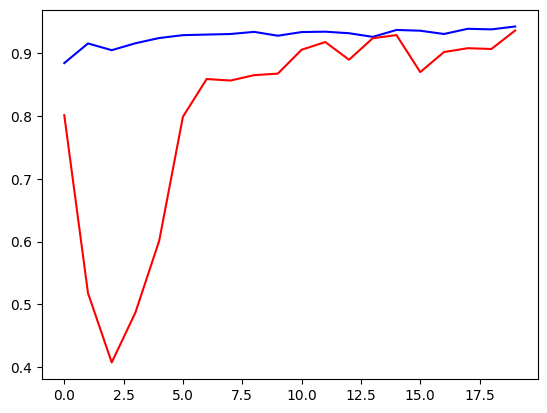

In [44]:
# نمایش عملکرد مدل روی اکیورسی

plt.plot(trained_model.history['accuracy'], color='blue') # داده ترین
plt.plot(trained_model.history['val_accuracy'], color='red') # داده تست

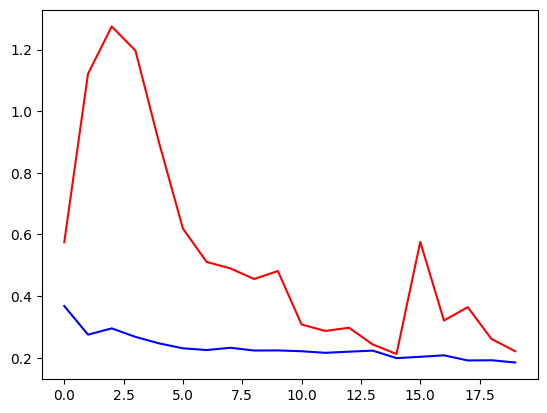

In [45]:
# نمایش عملکرد مدل روی تابع هزینه

plt.plot(trained_model.history['loss'], color='blue') # داده ترین
plt.plot(trained_model.history['val_loss'], color='red') # داده تست

# Testing

In [47]:
# تست کردن مدل روی داده واقعی

image = cv2.imread('mask.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## کراپ کردن چهره از تصویر

# لود مدل تشخیص چهره
face_detector_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# تشخیص چهره ها
faces = face_detector_model.detectMultiScale(image, minNeighbors=10, minSize=(100, 100))
print(faces)
# کراپ کردن چهره

for face in faces:
    print(face)
    face = image[face[1]:face[3] + face[1], face[0]:face[2] + face[0]]

    # ریسایز کردن
    face = cv2.resize(face, (216, 216))

    # نرمالایز کردن
    face = face.astype('float32') / 255.0

    # اضافه کردن بعد بچ. برای ورودی مدل لازمه که تعداد مشخص باشه
    face = np.expand_dims(face, axis=0)  # شکل از (216, 216, 3) به (1, 216, 216, 3) تغییر میکنه

  # پیشبینی توسط مدل
    model = keras.models.load_model('face_mask_detector.h5') # برای تنوع از مدل سیو شده استفاده میکنیم
    prediction = model.predict(face)
    print(prediction)

    class_idx = np.argmax(prediction[0]) # ایندکس بیشترین عدد
    print(class_idx)

    classes = ['Without Mask', 'With Mask', 'Incorrect Mask']  # ترتیب بر اساس وان هات
    label = classes[class_idx]

    print(f"Predicted class: {label}")

[[349  78 117 117]
 [544 105 116 116]]
[349  78 117 117]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


[[0.59294504 0.32702333 0.08003163]]
0
Predicted class: Without Mask
[544 105 116 116]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
[[2.7602704e-04 9.7889733e-01 2.0826675e-02]]
1
Predicted class: With Mask
